In [45]:
import matplotlib
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from mite.filters import ParallelFilter
from mite.filters.time import MeanAbsoluteValueFilter, VarianceFilter, WaveformLengthFilter, SlopeSignChangeFilter, \
    ZeroCrossingsFilter
from mite.filters.wavelet.WaveletTransformFilter import WaveletTransformFilter
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
matplotlib.use('QT5Agg')
%matplotlib inline

In [2]:
hf = h5py.File('s15data.mat', 'r')
data = hf.get('dat')
data = np.array(data)

In [3]:
y = data[8, :]
y_means = np.mean(y.reshape(-1, 100), axis=1)
diff = (np.max(y) - np.min(y))/3
bins = np.array([np.min(y), np.min(y) + diff, np.min(y) + 2*diff, np.max(y)])
y_binned = np.digitize(y_means, bins)

ds_data = data[0:10:-1]
sampling_rate = 10240

# processing variables
window_size = 100
window_step = 100

In [4]:
td5 = ParallelFilter(filters=[MeanAbsoluteValueFilter(),
                              VarianceFilter(),
                              WaveformLengthFilter(),
                              SlopeSignChangeFilter(),
                              ZeroCrossingsFilter()])

cwt = WaveletTransformFilter()

In [54]:
window = []
tfeat = []
features = []

sample = 0
t = 0
for sample in tqdm(range(0, np.shape(data)[1], 100)):
    window = data[0:6, sample:sample+100]  # grab device measurements
    features.append(cwt.filter(np.transpose(window)))  # extract features
    t = (sample + 100) / sampling_rate
    tfeat.append(t)  # save timestamp

raw = data[0:sample]
traw = range(sample)
tfeat = np.hstack(tfeat)
features = np.array(features)
features = np.vstack(features)

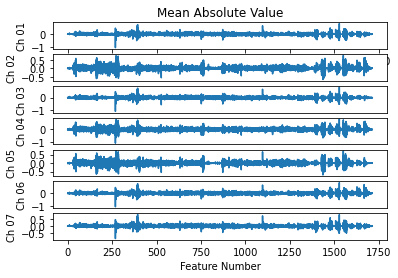

In [59]:
fig = plt.figure()
for i in range(7):
    ax = fig.add_subplot(7, 1, i + 1)
    ax.plot(tfeat, features[:, i])

    # ax.set_ylim( 0.35, 0.65 )
    ax.set_ylabel('Ch %02d' % (i + 1))

    if i == 0:
        ax.set_title('Mean Absolute Value')
    elif i == 6:
        ax.set_xlabel('Feature Number')
    else:
        ax.set_xticks([])
plt.show()

In [63]:
pca = PCA(n_components=10)
pca.fit(features)
X = pca.transform(features)
y = y_binned[:np.shape(features)[0]]

In [67]:
np.save('wt_features', features)
np.save('wt_features_pca', X)

Feature 0: 1.876925 0.153063
Feature 1: 1.056741 0.347589
Feature 2: 0.794175 0.451955
Feature 3: 2.280424 0.102244
Feature 4: 2.892330 0.055449
Feature 5: 0.264703 0.767434
Feature 6: 1.993469 0.136225
Feature 7: 3.767673 0.023108
Feature 8: 0.944007 0.389068
Feature 9: 0.489848 0.612721


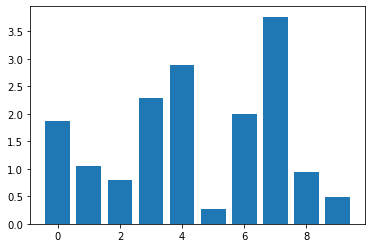

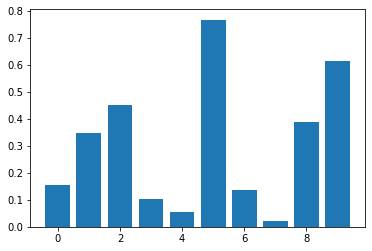

In [65]:
f, p = f_classif(X, y)
for i in range(len(f)):
    print('Feature %d: %f %f' % (i, f[i], p[i]))
# plot the scores
plt.bar([i for i in range(len(f))], f)
plt.show()
plt.bar([i for i in range(len(p))], p)
plt.show()

(array([ 1179.472,  3933.334,  2123.613, 14575.2  ,  7268.144, 11700.31 ,
           10.7  ,  2033.121,   420.048,  7302.211,  1894.336,  2552.511,
          820.209,  3153.156,  1805.601, 12938.636,  5401.112, 20670.523,
         3184.657,   887.411,  3710.698, 13699.623,  8573.967, 17111.542,
         6624.245,   666.259,  3764.825,  9032.6  ,  5632.77 ,  7123.272]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))